In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import os 
import matplotlib.pyplot as plt

In [2]:
def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^w + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    return dist
def cal_perplexity(dist, idx=0, beta=1.0):
    '''计算perplexity, D是距离向量，
    idx指dist中自己与自己距离的位置，beta是高斯分布参数
    这里的perp仅计算了熵，方便计算
    '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    perp = np.log(sum_prob) + beta * np.sum(dist * prob) / sum_prob
    prob /= sum_prob
    return perp, prob
def seach_prob(x, tol=1e-5, perplexity=30.0):
    '''二分搜索寻找beta,并计算pairwise的prob
    '''
 
    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity)
 
    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))
 
        betamin = -np.inf
        betamax = np.inf
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])
 
        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
 
            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    return pair_prob
def pca(x, no_dims):
    ''' PCA算法
    使用PCA先进行预降维
    '''
    print("Preprocessing the data using PCA...")
    (n, d) = x.shape
    x = x - np.tile(np.mean(x, 0), (n, 1))
    l, M = np.linalg.eig(np.dot(x.T, x))
    y = np.dot(x, M[:,0:no_dims])
    return y
def tsne(x, no_dims, initial_dims, perplexity, max_iter):
    """Runs t-SNE on the dataset in the NxD array x
    to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(x, no_dims, perplexity),
    where x is an NxD NumPy array.
    """
 
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array x should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1
 
    # 初始化参数和变量
    x = pca(x, initial_dims).real
    (n, d) = x.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    y = np.random.randn(n, no_dims)
    dy = np.zeros((n, no_dims))
    iy = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
 
    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    # early exaggeration
    P = P * 4
    P = np.maximum(P, 1e-12)
 
    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(y, y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
 
        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)
 
        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dy > 0) != (iy > 0)) + (gains * 0.8) * ((dy > 0) == (iy > 0))
        gains[gains < min_gain] = min_gain
        iy = momentum * iy - eta * (gains * dy)
        y = y + iy
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            if iter > 100:
                C = np.sum(P * np.log(P / Q))
            else:
                C = np.sum( P/4 * np.log( P/4 / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
        # Stop lying about P-values
        if iter == 100:
            P = P / 4
    print("finished training!")
    return y

In [86]:
X1 = pd.read_excel('ggp1D-validx.xlsx', header=None).values
labels = pd.read_excel('ggp1D-validy.xlsx', header=None).values

In [87]:
X1.shape

(800, 200)

In [88]:
# Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
#X2 = intermediate_output
Y = tsne(X1, 2, 200, 30.0, 1000)
#Y2 = tsne(X2, 2, 6, 30.0, 500)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing pair_prob for point 0 of 800 ...
Computing pair_prob for point 500 of 800 ...
Mean value of sigma:  2.1531716677996275
Iteration  100 : error is  1.481725815184367
Iteration  200 : error is  0.49458763130002154
Iteration  300 : error is  0.4659204172394976
Iteration  400 : error is  0.46011025874062456
Iteration  500 : error is  0.45760941417069895
Iteration  600 : error is  0.45619880313996747
Iteration  700 : error is  0.4553011849483905
Iteration  800 : error is  0.4546948278862734
Iteration  900 : error is  0.45426891186555374
Iteration  1000 : error is  0.4539608476248138
finished training!


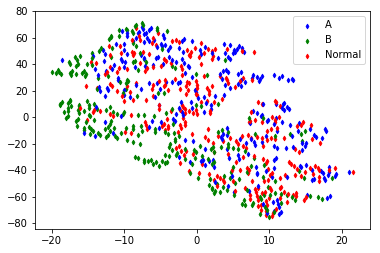

In [89]:
from matplotlib import pyplot as plt
for i in range(len(labels)):
    if labels[i] == 0:
        plt.scatter(Y[i:i+1, 0], Y[i:i+1 ,1],10, color='red',marker =  'd')
    if labels[i] == 1:
        plt.scatter(Y[i:i+1, 0], Y[i:i+1, 1],10,color='green',marker =  'd')
    if labels[i] == 2:
        plt.scatter(Y[i:i+1, 0], Y[i:i+1 ,1],10,color='blue',marker =  'd')
plt.legend(["A","B","Normal"])
plt.savefig("original-1Dggp.jpg",dpi = 1000)
plt.show()

In [104]:
X2 = pd.read_excel('ggp1D-dense2.xlsx', header=None).values
X2.shape

(800, 3)

In [95]:
train_mean = np.mean(X2, axis=0)
train_std = np.std(X2, axis=0)
X2 = (X2 - train_mean) / train_std

In [105]:
Y = tsne(X2, 2, 3, 30.0, 1000)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing pair_prob for point 0 of 800 ...
Computing pair_prob for point 500 of 800 ...
Mean value of sigma:  0.9293214647520195
Iteration  100 : error is  1.3871281754703995
Iteration  200 : error is  0.4304154691752179
Iteration  300 : error is  0.40802471694606135
Iteration  400 : error is  0.40308626780779505
Iteration  500 : error is  0.4005211609588452
Iteration  600 : error is  0.39876244653989595
Iteration  700 : error is  0.3973960903499584
Iteration  800 : error is  0.39626730472305954
Iteration  900 : error is  0.39530428529060846
Iteration  1000 : error is  0.39446256210370373
finished training!


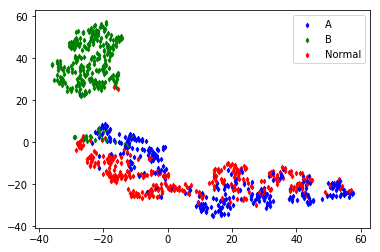

In [106]:
  for i in range(len(labels)):
      if labels[i] == 0:
          plt.scatter(Y[i:i+1, 0], Y[i:i+1 ,1],10, color='red',marker = 'd')
      if labels[i] == 1:
          plt.scatter(Y[i:i+1, 0], Y[i:i+1, 1],10,color='green',marker =  'd')
      if labels[i] == 2:
          plt.scatter(Y[i:i+1, 0], Y[i:i+1 ,1],10,color='blue',marker =  'd')
plt.legend(["A","B","Normal"])
plt.savefig("ggp1D-dense2.jpg",dpi = 1000)
plt.show()